# Predict habitat for native species

## Set up notebook

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import logging

logging.basicConfig(level=logging.INFO)

## Import configuration and modules

In [6]:
from remote_sensing_tools.stac_configuration import de_australia_stac_config
from remote_sensing_tools.raster_base import RasterBase, QueryParams, LoadParams
from rasterstats import zonal_stats
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier

## Query satellite products

### Get DEA configuration and list collections

In [7]:
config = de_australia_stac_config

config.list_collections()

INFO:remote_sensing_tools.stac_utils:ga_s2am_ard_3 - Sentinel-2a
INFO:remote_sensing_tools.stac_utils:ga_s2bm_ard_3 - Sentinel-2b
INFO:remote_sensing_tools.stac_utils:ga_ls8cls9c_gm_cyear_3 - Landsat-8-9-gm


### Set query parameters

In [8]:
query_params = QueryParams(
    bbox=(145.02, -37.46, 145.01, -37.45),
    start_date="2023-01-01",
    end_date="2023-12-31",
)

### Load DEA products:
* Landsat 8 & 9 yearly geomedian

In [9]:
# Landsat 8 & 9 yearly geomedian: load only geomedian spectral bands for now
params_ls_8_9_gm = LoadParams(
    crs="EPSG:3577",
    resolution=30,
    bands=("nbart_blue", "nbart_green", "nbart_red", "nbart_nir", "nbart_swir_1", "nbart_swir_2"),
)
stac_raster = RasterBase.from_stac_query(
    config=config,
    collections=["ga_ls8cls9c_gm_cyear_3"],
    query_params=query_params,
    load_params=params_ls_8_9_gm,
)
stac_raster

INFO:remote_sensing_tools.raster_base:No masks were found for the requested collections


* Sentinel-2 Barest Earth

* SRTM DEM
* Multi-scale Topographic Position Index (TPI)
* Weathering Intensity

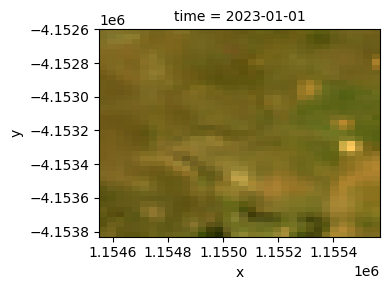

In [15]:
stac_raster.data.isel(time=slice(0,1))[
    ["nbart_red", "nbart_green", "nbart_blue"]
].to_array().plot.imshow(col="time", vmin=0, vmax=3000)

## Band indices calculation

## Object-based classification for native species habitat prediction

### Load pre-processed training points

In [ ]:
# Frog presence points from ALA, with pseodo absence points pre-generated


### Image segmentation

### Object-level features calculation

### Model training

### Prediction